# 음성 분류 경진대회 EDA

이번 대회는 음성 데이터를 이용하여 0~9까지 숫자를 분류하는 대회입니다.

대회를 시작하기 앞서 어떤 데이터가 주어졌고 어떤 방식으로 활용할 수 있을지 데이터를 분석하고 시각화하며 인사이트를 얻어내는 작업이 필요합니다.

음성 데이터를 이용한 탐색적 자료 분석을 간단히 진행해보도록 하겠습니다.

## 분석 환경 준비

In [1]:
import librosa
import librosa.display as dsp
from IPython.display import Audio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

## CSV 파일 EDA

우선 train csv 파일의 데이터부터 불러오겠습니다.

In [2]:
train = pd.read_csv('data/train.csv')
train.head()

,file_name,label
0,001.wav,9
1,002.wav,0
2,004.wav,1
3,005.wav,8
4,006.wav,0


In [3]:
train.shape

(400, 2)

400개 행과 3개의 열로 이루어진 데이터 프레임 입니다.

그럼 라벨은 각각 몇개씩 있는지 확인해 보겠습니다.

In [5]:
train.label.groupby(train.label).count()

label
0    40
1    40
2    40
3    40
4    40
5    40
6    40
7    40
8    40
9    40
Name: label, dtype: int64

In [11]:
X = train.id.groupby(train.label).count().index
Y = train.id.groupby(train.label).count()

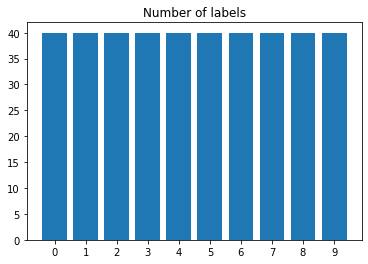

In [20]:
plt.bar(X, Y)
plt.xticks(X)
plt.title("Number of labels")
plt.show()

모두 0~9의 숫자가 균일하게 40개씩 분포 되어있는 것을 확인 할 수 있습니다.

## WAV 파일 EDA

### 오디오 시각화
그럼 음성 파일로부터 간단히 0~9까지 데이터를 하나씩 추출하여 소리를 들어보겠습니다.

In [24]:
def get_audio(num = 0):
    # Audio Sample Directory
    sample = os.listdir('data/train')
    temp = train[train.label == num].file_name
    file_name = temp[temp.index[0]]
    
    file = 'data/train/' + file_name
    # Get Audio from the location
    data,sample_rate = librosa.load(file)
    
    # Plot the audio wave
    dsp.waveshow(data,sr=sample_rate)
    plt.show()
    
    # Show the widget
    return Audio(data=data,rate=sample_rate)

* 숫자 0의 음성

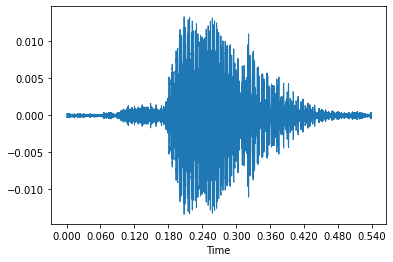

In [26]:
get_audio(0)

* 숫자 1의 음성

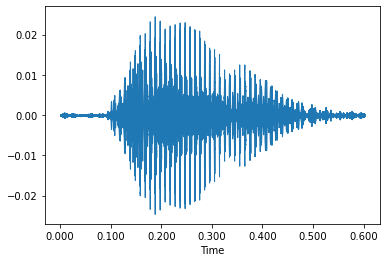

In [27]:
get_audio(1)

* 숫자 2의 음성

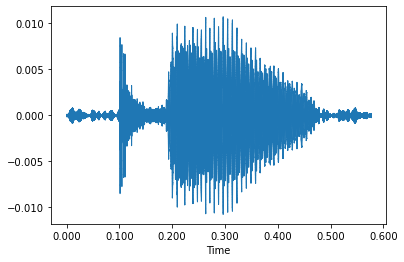

In [28]:
get_audio(2)

* 숫자 3의 음성

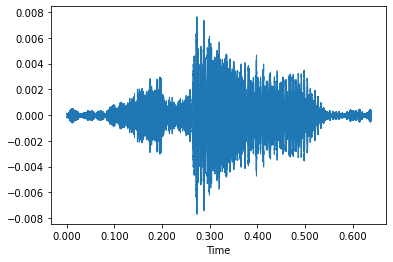

In [29]:
get_audio(3)

* 숫자 4의 음성

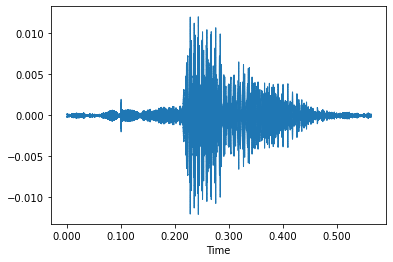

In [30]:
get_audio(4)

* 숫자 5의 음성

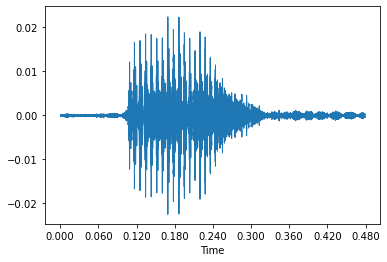

In [31]:
get_audio(5)

* 숫자 6의 음성

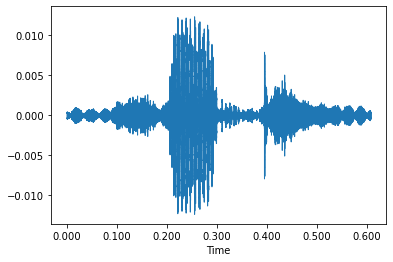

In [32]:
get_audio(6)

* 숫자 7의 음성

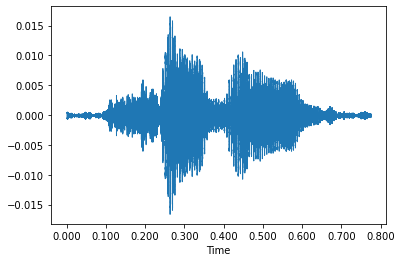

In [33]:
get_audio(7)

* 숫자 8의 음성

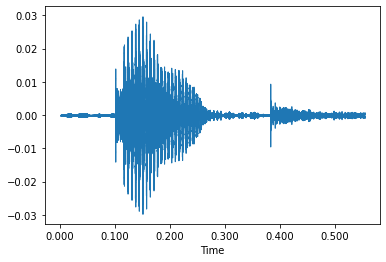

In [34]:
get_audio(8)

* 숫자 9의 음성

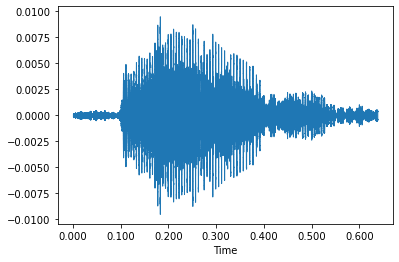

In [25]:
get_audio(9)

## 퓨리에 변환

음성 데이터를 분석하기 위하여 주파수(frequency)를 성분을 뽑아내야 한다면 퓨리에 변환(Fourier Transform)을 해야 합니다.

퓨리에 변환은 간단히 설명하자면 **'입력 신호를 다양한 주파수를 가지는 주기함수들로 분해하는 것'** 입니다.

주기함수들을 분해함으로써 음성 데이터에서 노이즈 및 배경 소리로 부터 실제로 유용한 소리의 데이터, 즉 특징을 추출하는 것 입니다.

그럼, **FFT(Fast Fourier Transform)** 를 통해 원본 소리 데이터를 형성하는 주파수(frequency)의 정도를 파악하고 시각화를 해 봅시다.

In [36]:
def fourier_transform(num = 0):
    # Audio Sample Directory
    sample = os.listdir('data/train')
    temp = train[train.label == num].file_name
    file_name = temp[temp.index[0]]
    
    file = 'data/train/' + file_name
    # Get Audio from the location
    data,sample_rate = librosa.load(file)

    fft = np.fft.fft(data) 

    magnitude = np.abs(fft)
    frequency = np.linspace(0, sample_rate, len(magnitude))

    left_frequency = frequency[:int(len(frequency)/2)]
    left_magnitude = magnitude[:int(len(magnitude)/2)]

    fig = plt.figure(figsize = (14,5))
    plt.plot(left_frequency, left_magnitude)
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.title(f"Fourier transform of audio label {num}")
    plt.show()

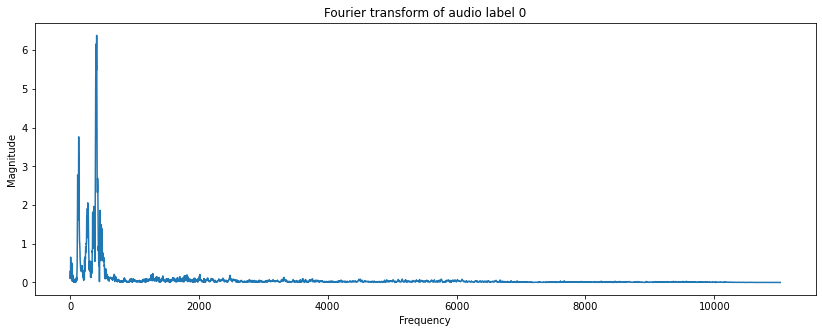

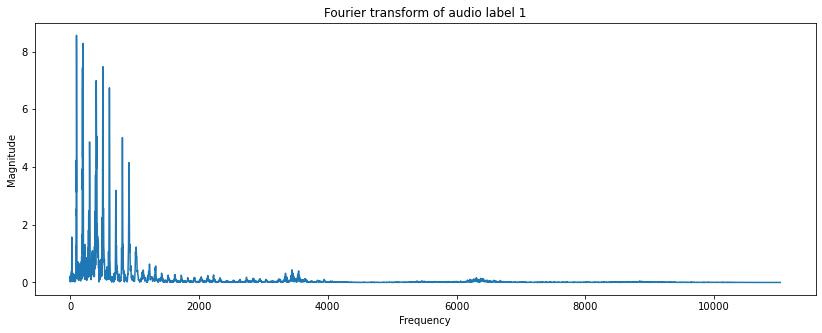

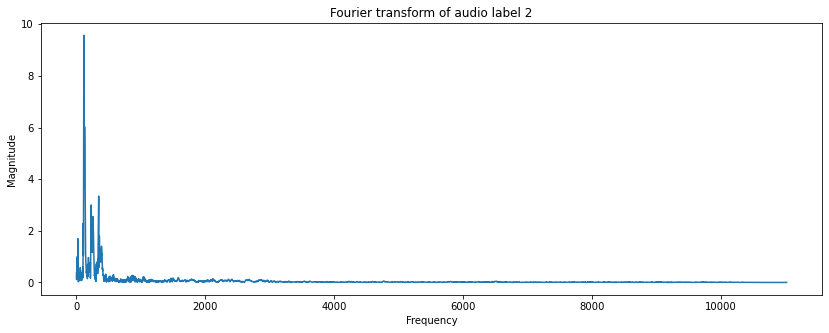

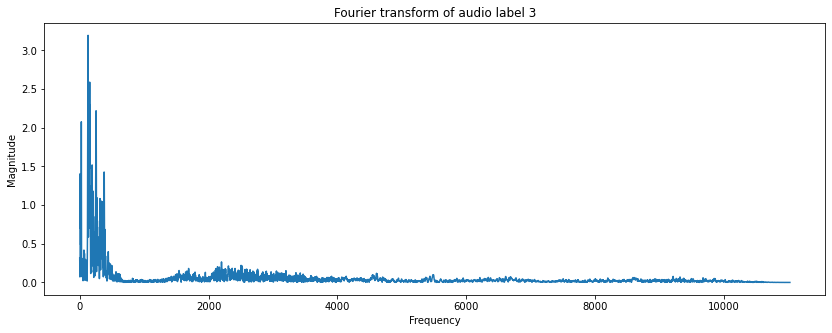

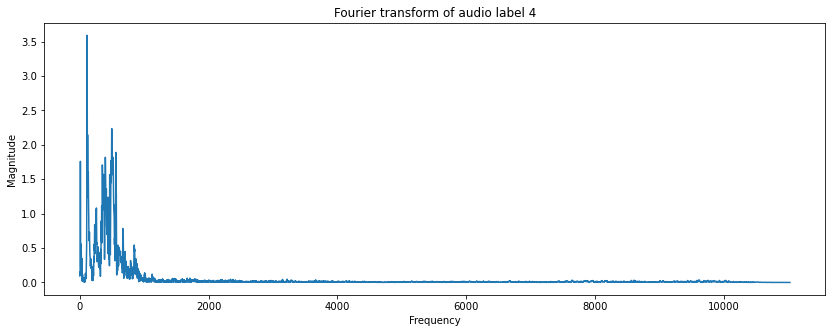

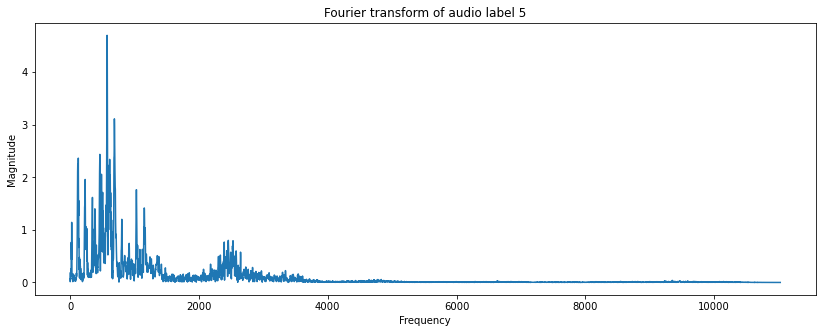

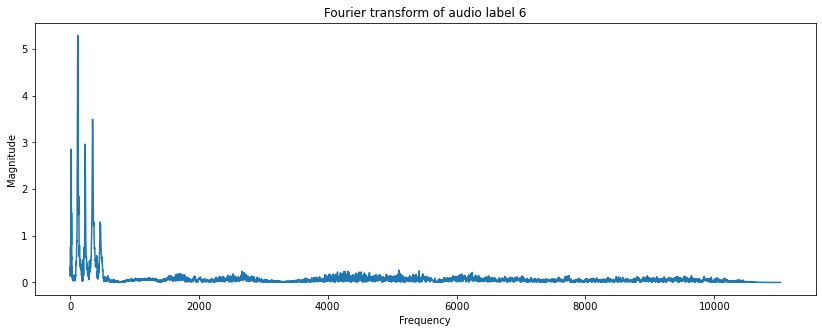

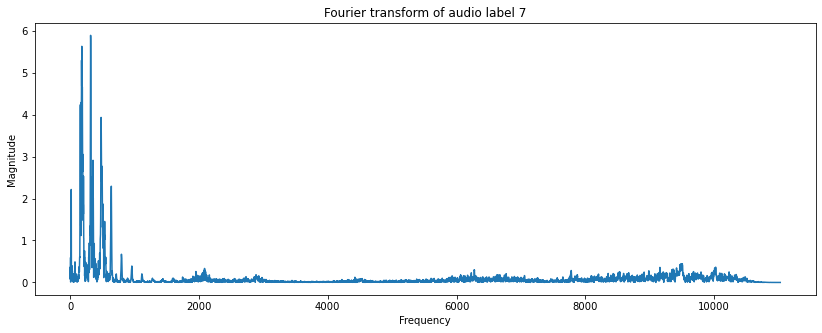

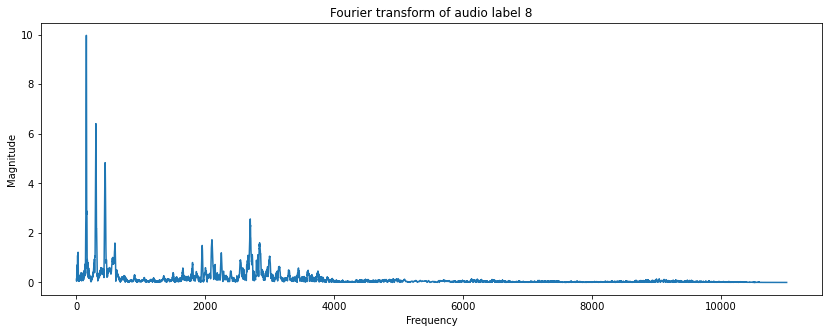

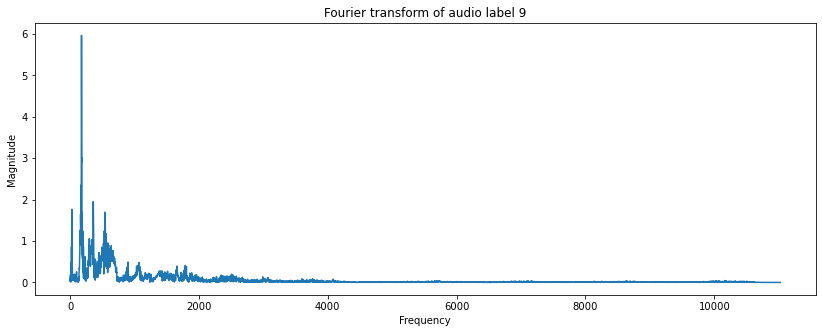

In [46]:
for i in range(0,10):
    fourier_transform(i)

숫자에 따라 에너지의 분포가 상이 하다는 것을 확인할 수 있습니다.

### Mel Spectrogram   

Spectogram은 소리나 파동을 시각화하여 파악하기 위한 도구로, 파형(waveform)과 스펙트럼(spectrum)의 특징이 조합되어 있습니다.

Mel Spetrogram은 주파수를 **mel-scale**로 변환한 형태입니다.

낮은 주파수를 높은 주파수보다 더 예민하게 받아들이므로 이 주파수를 mel scale로 볼 수 있게 하는 방법입니다.

#### **Mel-scale**

**Mel은 사람의 달팽이관을 모티브로 따온 값**입니다.

달팽이관은 주파수가 낮은 대역에서는 변화하는 주파수를 잘 감지하는데, 

주파수가 높은 대역에서는 주파수 감지를 잘 하지 못합니다. (주파수 간격이 넓어짐)

이러한 원리를 이용해서 filter, scaling 해줄 수 있는데, 이때 이 기준을 Mel-Scale 이라고 합니다.


#### Argument 

1. n_fft : 한 번 fft를 해 줄 만큼의 sequence 길이 

    여기서 n_fft는 window size라고도 부르는데, frame의 length를 결정하는 파라미터 입니다.

    사람의 목소리는 대부분 16000Hz 안에 포함이 되는데,

    일반적으로 자연어 처리에서는 음성을 25m의 크기를 기본으로 하고 있습니다.

    따라서 16000Hz인 음성에서는 25m의 음성의 크기를 가지고 있으면 n_fft는 16000 * 0.025 = 400 (sampling rate * frame_length = n_fft)가 됩니다.

2. hop_length : window 간의 거리 

    hop_length도 마찬가지로 window 간의 거리이므로 sampling rate * frame_stride 가 됩니다.

3. win_length : 윈도우 길이

    보통 win_length를 지정하지 않으면 n_fft가 됩니다.

In [49]:
def Mel_s(num = 0, frame_length = 0.025, frame_stride = 0.010):

    sample = os.listdir('data/train')
    temp = train[train.label == num].file_name
    file_name = temp[temp.index[0]]
    
    file = 'data/train/' + file_name
    data,sample_rate = librosa.load(file, sr = 16000)
    
    input_nfft = int(round(sr*frame_length))
    input_stride = int(round(sr*frame_stride))
    
    S = librosa.feature.melspectrogram(y=data, n_mels=100, n_fft=input_nfft, hop_length=input_stride)
    
    print("Wav length: {}, Mel_S shape:{}".format(len(data)/sample_rate, np.shape(S)))
    
    S_dB  = librosa.power_to_db(S, ref=np.max)
    fig = plt.figure(figsize = (14,5))
    librosa.display.specshow(S_dB, 
                             sr=sample_rate, 
                             hop_length=input_stride,
                             x_axis='time',
                             y_axis='log')
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar(format='%+2.0f dB')
    plt.title(f"Mel spectrogram of audio label {num}")
    plt.show()

Wav length: 0.5379375, Mel_S shape:(100, 54)
16000


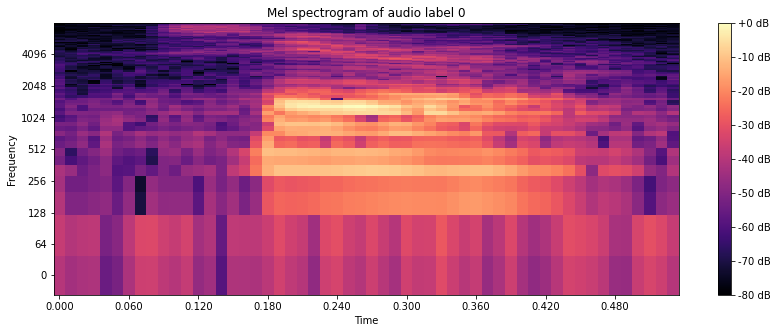

Wav length: 0.602125, Mel_S shape:(100, 61)
16000


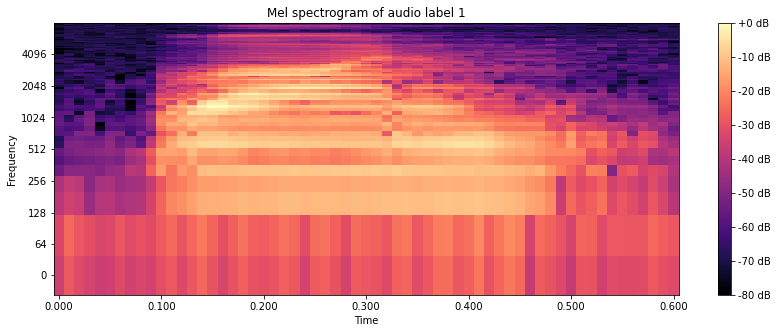

Wav length: 0.5765, Mel_S shape:(100, 58)
16000


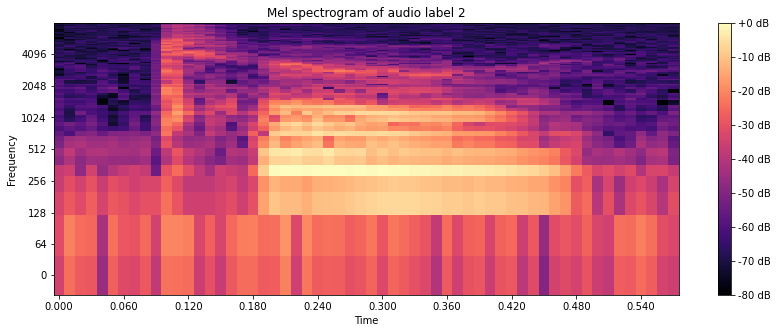

Wav length: 0.6379375, Mel_S shape:(100, 64)
16000


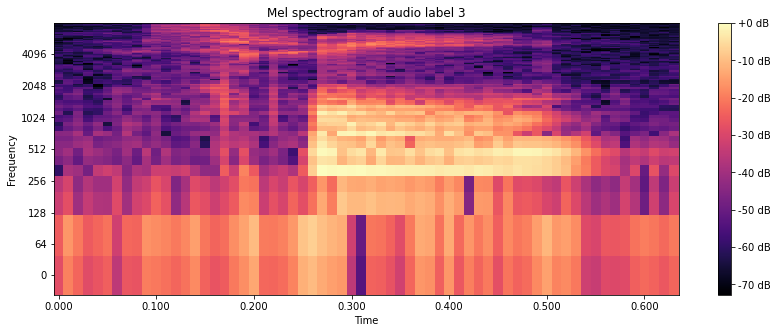

Wav length: 0.5633125, Mel_S shape:(100, 57)
16000


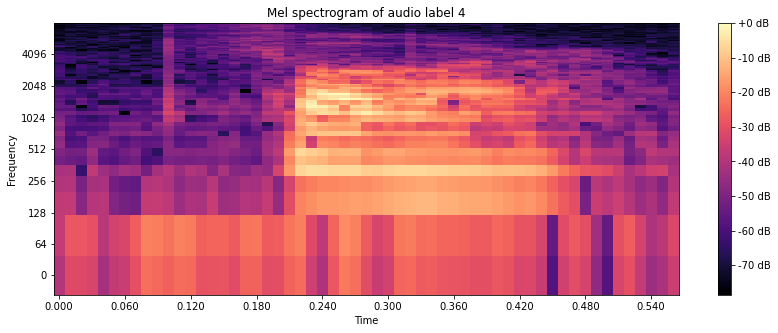

Wav length: 0.4784375, Mel_S shape:(100, 48)
16000


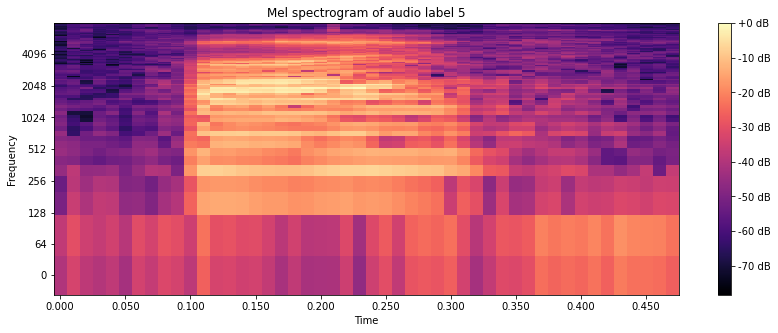

Wav length: 0.6081875, Mel_S shape:(100, 61)
16000


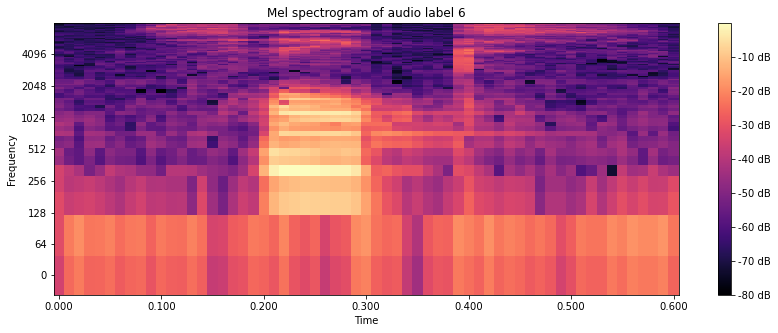

Wav length: 0.775125, Mel_S shape:(100, 78)
16000


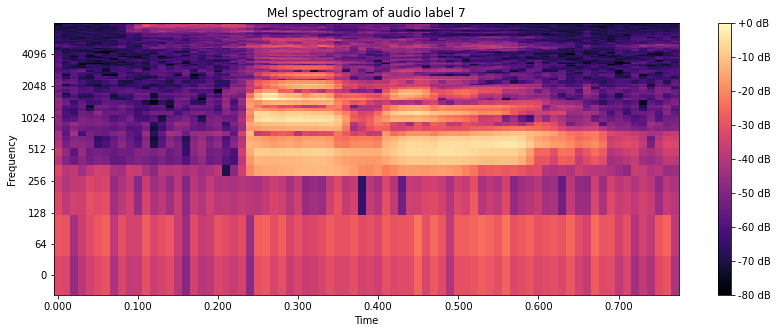

Wav length: 0.553375, Mel_S shape:(100, 56)
16000


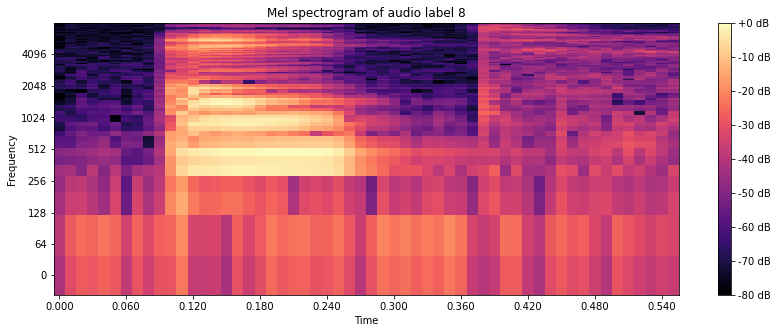

Wav length: 0.6374375, Mel_S shape:(100, 64)
16000


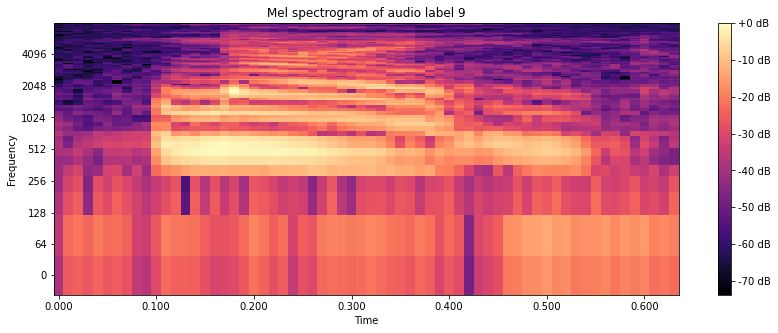

In [50]:
for i in range(0,10):
    Mel_s(i)